In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2

from keras.preprocessing.sequence import pad_sequences
from DeepHeart.deepheart.parser import PCG

np.random.seed(0)
pcg_raw = PCG('data/deepheart/', doFFT=False)
pcg_raw.initialize_wav_data()
X = pcg_raw.X
Y = pcg_raw.y
y = np.array(["Normal" if row[0] == 1 else "Abnormal" for row in Y])
n_min = min(len(x) for x in X)
n_max = max(len(x) for x in X)
#X = pad_sequences(X, maxlen=n_max, value=-1.)

/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


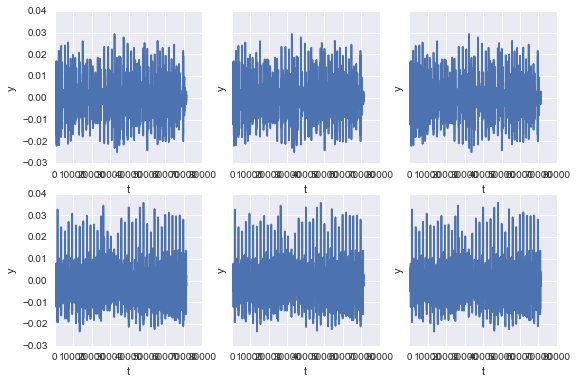

In [2]:
fig, ax = plt.subplots(2, 3, sharey=True)
for j in range(3):
    i = np.where(y == "Normal")[0][0]
    ax[0][j].plot(X[i], '-')
    ax[0][j].set(xlabel="t", ylabel="y")
    i = np.where(y == "Abnormal")[0][0]
    ax[1][j].plot(X[i], '-')
    ax[1][j].set(xlabel="t", ylabel="y")

In [ ]:
from dask.diagnostics import ProgressBar

pbar = ProgressBar()

In [ ]:
from cesium.featurize import featurize_time_series

features_to_use = ['amplitude',
                   'percent_beyond_1_std',
                   'maximum',
                   'max_slope',
                   'median',
                   'median_absolute_deviation',
                   'percent_close_to_median',
                   'minimum',
                   'skew',
                   'std',
                   'weighted_average'
                  ]
fset_cesium = featurize_time_series(times=None, values=X, features_to_use=features_to_use, targets=y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

from cesium.build_model import build_model_from_featureset

train, test = train_test_split(np.arange(len(X)), random_state=0)

rfc_param_grid = {'n_estimators': [8, 16, 32, 64, 128, 256, 512, 1024]}
model_cesium = build_model_from_featureset(fset_cesium.isel(name=train),
                                           RandomForestClassifier(max_features='auto',
                                                                  random_state=0),
                                           params_to_optimize=rfc_param_grid)

#knn_param_grid = {'n_neighbors': [1, 2, 3, 4]}
#model_guo = build_model_from_featureset(fset_guo.isel(name=train),
#                                        KNeighborsClassifier(),
#                                        params_to_optimize=knn_param_grid)
#model_dwt = build_model_from_featureset(fset_dwt.isel(name=train),
#                                        KNeighborsClassifier(),
#                                        params_to_optimize=knn_param_grid)

In [ ]:
import pywt

n_channels = 5
guo_features = {
    'mean': mean_signal,
    'std': std_signal,
    'mean2': mean_square_signal,
    'abs_diffs': abs_diffs_signal,
    'skew': skew_signal
}
dwts = [pywt.wavedec(m, pywt.Wavelet('db1'), level=n_channels-1) for m in X]
fset_dwt = featurize_time_series(times=None, values=dwts,
                                 features_to_use=list(guo_features.keys()),
                                 targets=y, custom_functions=guo_features)
print(fset_dwt)